# Experimento: A "Folha de Borracha" e a Geometria Exata
## Mapeamento de Autovetores no Espaço Cartesiano

Neste experimento corrigido, implementaremos o conceito da "folha de borracha" utilizando um mapeamento de coordenadas estritamente Cartesiano. 

**O Desafio das Coordenadas:**
Imagens de computador usam coordenadas `(linha, coluna)` com o eixo vertical invertido. Para que os Autovetores $v$ correspondam visualmente à imagem, precisamos criar uma malha onde o centro da imagem seja `(0,0)` e aplicar a transformação inversa $A^{-1}$ para mapear matematicamente cada pixel.

**A Prova de Fogo:**
Desenharemos um marcador (um ponto colorido) na ponta de cada autovetor. 
* Na imagem original, a ponta apontará para um detalhe específico (ex: uma dobra do vestido).
* Na imagem transformada, a seta mudará de comprimento multiplicada pelo **Autovalor ($\lambda$)**, mas manterá a direção. O marcador deverá repousar sobre o **exato mesmo pixel** da imagem original!

In [14]:
import os
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from typing import Tuple, Optional

# Semente para reprodutibilidade
np.random.seed(28)

# Paleta de cores didática
COR_AZUL_PRINCIPAL = "#0D134C"
COR_VERMELHO = "#DD303E" # Usado para o autovetor 1
COR_VERDE = "#6CA30B"    # Usado para o autovetor 2
COR_BRANCO = "#FFFFFF"    # Usado para o autovetor 2

# URL da Mona Lisa (Wikimedia Commons)
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/402px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg"
IMAGE_PATH_LOCAL = "../data/mona_lisa_sample.jpg"

def carregar_imagem(url: str, local_path: str) -> Optional[np.ndarray]:
    """Lê a imagem local ou faz o download seguro se não existir."""
    if os.path.exists(local_path):
        return np.array(Image.open(local_path).convert('L'))
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        img_pil = Image.open(BytesIO(response.content)).convert('L')
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        img_pil.save(local_path)
        return np.array(img_pil)
    except Exception as e:
        print(f"Erro ao obter imagem: {e}\nBaixe manualmente '{url}' e salve como '{local_path}'.")
        raise FileNotFoundError("Imagem não encontrada.")

try:
    img_array = carregar_imagem(IMAGE_URL, IMAGE_PATH_LOCAL)
    print(f"Imagem carregada. Dimensões: {img_array.shape}")
except FileNotFoundError:
    pass

Imagem carregada. Dimensões: (599, 402)


## 1. Definindo a Matriz de Transformação

Utilizaremos uma matriz de transformação que gera uma deformação clara (esmagando em uma direção e esticando na outra).
$$A = \begin{pmatrix} 1.5 & 0.8 \\ 0.8 & 1.5 \end{pmatrix}$$

In [15]:
# Definir a Matriz A no espaço Cartesiano (X, Y)
A = np.array([
    [1.5, 0.8],
    [0.8, 1.5]
])

# Calcular autovalores e autovetores
evals, evecs = np.linalg.eig(A)

print("Análise Matemática da Matriz de Transformação:")
for i in range(2):
    print(f"Autovetor {i+1}: {evecs[:, i].round(3)} | Autovalor (λ): {evals[i]:.2f}")
    if evals[i] > 1:
        print("  -> O espaço será ESTICADO ao longo desta linha.\n")
    else:
        print("  -> O espaço será ENCOLHIDO ao longo desta linha.\n")

Análise Matemática da Matriz de Transformação:
Autovetor 1: [0.707 0.707] | Autovalor (λ): 2.30
  -> O espaço será ESTICADO ao longo desta linha.

Autovetor 2: [-0.707  0.707] | Autovalor (λ): 0.70
  -> O espaço será ENCOLHIDO ao longo desta linha.



## 2. O Motor de Deformação Cartesiana (Warping)

Aqui corrigimos o problema das coordenadas. Criamos um grid onde $(0,0)$ é o centro absoluto da imagem. Em seguida, mapeamos cada ponto $(X, Y)$ da imagem final multiplicando por $A^{-1}$ para saber de qual ponto $(X_{orig}, Y_{orig})$ da imagem inicial ele "puxou" a cor.

In [16]:
def transformar_imagem_cartesiana(img: np.ndarray, matriz: np.ndarray) -> Tuple[np.ndarray, Tuple[float, float, float, float]]:
    """
    Aplica a transformação linear considerando o centro da imagem como (0,0) 
    e o eixo Y crescendo para cima.
    """
    H, W = img.shape
    A_inv = np.linalg.inv(matriz)
    
    # 1. Definir os cantos do espaço final para que a imagem não seja cortada
    corners = np.array([[-W/2, -H/2], [W/2, -H/2], [-W/2, H/2], [W/2, H/2]])
    new_corners = corners @ matriz.T
    min_x, max_x = new_corners[:, 0].min(), new_corners[:, 0].max()
    min_y, max_y = new_corners[:, 1].min(), new_corners[:, 1].max()
    
    out_W, out_H = int(np.ceil(max_x - min_x)), int(np.ceil(max_y - min_y))
    
    # 2. Criar a Malha Cartesiana de destino (Note que Y decresce de max_y para min_y para refletir o topo->base da matriz de pixels)
    x_lin = np.linspace(min_x, max_x, out_W)
    y_lin = np.linspace(max_y, min_y, out_H) 
    X, Y = np.meshgrid(x_lin, y_lin)
    
    # 3. Aplicar A^{-1} para encontrar as coordenadas originais correspondentes
    coords_flat = np.vstack((X.flatten(), Y.flatten()))
    orig_coords_flat = A_inv @ coords_flat
    
    X_orig = orig_coords_flat[0, :]
    Y_orig = orig_coords_flat[1, :]
    
    # 4. Converter as coordenadas originais Cartesianas de volta para índices (row, col) da imagem NumPy
    cols = X_orig + W/2
    rows = H/2 - Y_orig # Y é subtraído porque H/2 é o topo (linha 0)
    
    img_coords = np.vstack((rows, cols))
    
    # 5. Interpolar as cores
    img_transformada = ndimage.map_coordinates(img, img_coords, order=3, cval=255)
    img_transformada = img_transformada.reshape((out_H, out_W))
    
    # Extent para uso no matplotlib: [esquerda, direita, fundo, topo]
    extent_out = (min_x, max_x, min_y, max_y)
    
    return img_transformada, extent_out

# Executa a transformação matematicamente correta
img_transf, extent_transf = transformar_imagem_cartesiana(img_array, A)
extent_orig = (-img_array.shape[1]/2, img_array.shape[1]/2, -img_array.shape[0]/2, img_array.shape[0]/2)

## 3. A Prova Visual
Observe atentamente os círculos coloridos nas pontas das setas. Como esses vetores são autovetores, a transformação deforma a imagem estritamente ao longo dessas linhas. A consequência direta é que os círculos ancorados na ponta das setas originais cairão na mesma posição física do tecido da Mona Lisa na imagem transformada.

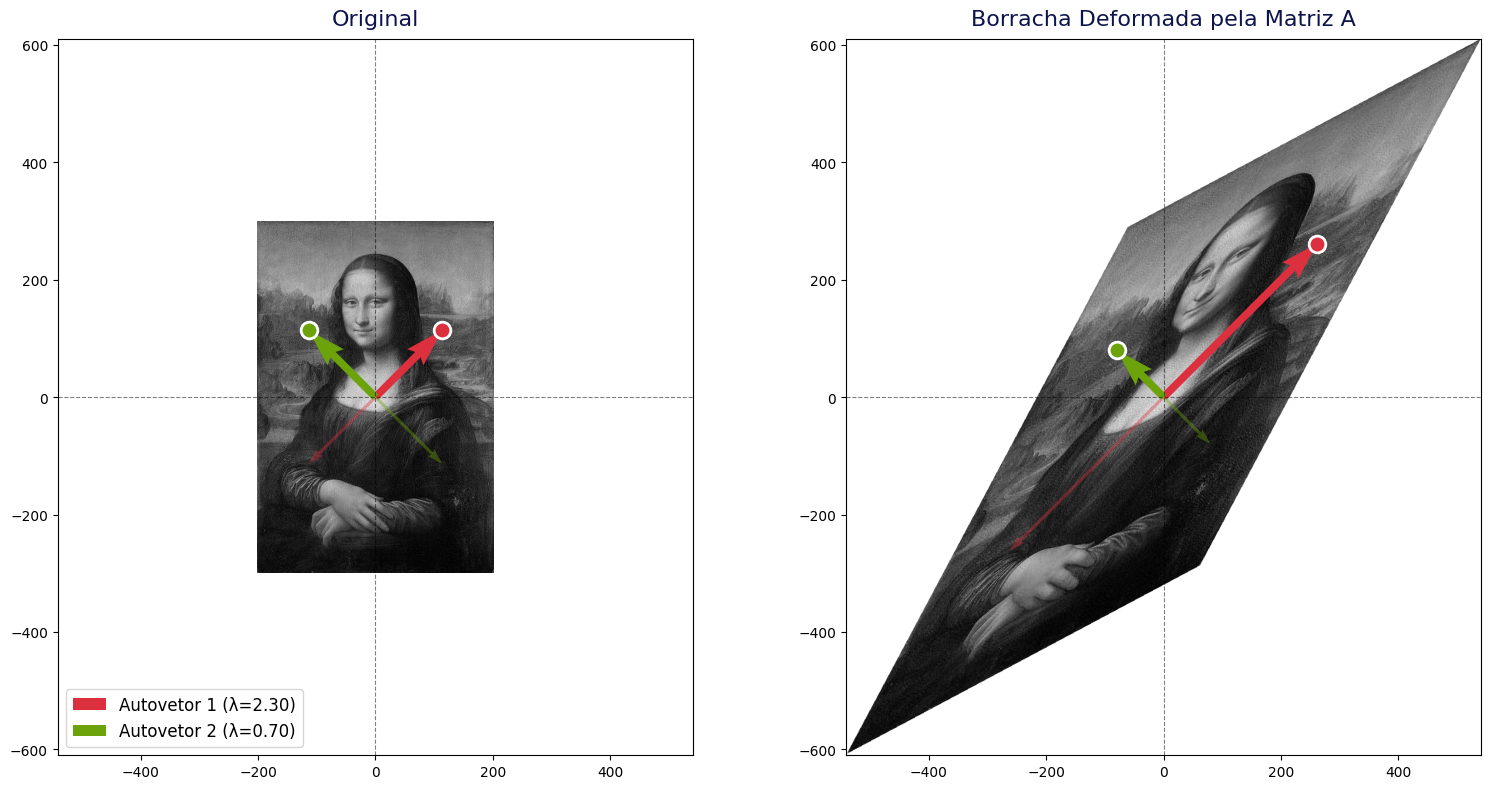

In [17]:
def plotar_prova_autovetores(img_orig, ext_orig, img_trans, ext_trans, val, vec):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), facecolor=COR_BRANCO)
    
    # Mostrando imagens com os eixos cartesianos reais
    axes[0].imshow(img_orig, cmap='gray', extent=ext_orig)
    axes[1].imshow(img_trans, cmap='gray', extent=ext_trans)
    
    axes[0].set_title("Original", fontsize=16, color=COR_AZUL_PRINCIPAL, pad=10)
    axes[1].set_title(f"Borracha Deformada pela Matriz A", fontsize=16, color=COR_AZUL_PRINCIPAL, pad=10)
    
    # Cores e configurações
    cores = [COR_VERMELHO, COR_VERDE]
    W_orig = ext_orig[1] * 2
    # Comprimento base das setas
    C = W_orig * 0.40 
    
    for ax, is_transf in zip(axes, [False, True]):
        ax.axhline(0, color='black', linewidth=0.8, alpha=0.5, ls='--')
        ax.axvline(0, color='black', linewidth=0.8, alpha=0.5, ls='--')
        
        for i in range(2):
            v_x, v_y = vec[0, i], vec[1, i]
            lambda_val = val[i]
            
            # Cálculo matemático crucial: 
            # Na original, a ponta está em C * v.
            # Na transformada, a ponta vai para A*(C * v) = C * A*v = C * lambda * v
            # Ou seja, o vetor apenas é escalado pelo autovalor!
            escala = lambda_val if is_transf else 1.0
            
            p_x = C * v_x * escala
            p_y = C * v_y * escala
            
            # Desenha a seta principal
            ax.quiver(0, 0, p_x, p_y, angles='xy', scale_units='xy', scale=1, 
                      color=cores[i], width=0.012, 
                      label=f"Autovetor {i+1} (λ={lambda_val:.2f})" if not is_transf else "")
            
            # Desenha a linha no sentido oposto para referência do eixo
            ax.quiver(0, 0, -p_x, -p_y, angles='xy', scale_units='xy', scale=1, 
                      color=cores[i], width=0.005, alpha=0.4)
            
            # Ponto de ancoragem na ponta da seta para provar a ausência de rotação
            ax.plot(p_x, p_y, marker='o', markersize=12, color=cores[i], markeredgecolor='white', markeredgewidth=2)
            
        ax.set_xlim(ext_trans[0], ext_trans[1])
        ax.set_ylim(ext_trans[2], ext_trans[3])
        if not is_transf:
            ax.legend(loc='lower left', fontsize=12)

    plt.tight_layout()
    os.makedirs("../outputs", exist_ok=True)
    plt.savefig("../outputs/mona_lisa_cartesiana_exata.png", dpi=200)
    plt.show()

plotar_prova_autovetores(img_array, extent_orig, img_transf, extent_transf, evals, evecs)